In [ ]:

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import itertools
import numpy as np
import json
import random as rd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go

### Basic upload preparation


Generates a PPI network, then restriicts to a subgraph. The graph's node and edge structure will serve as an example dataset for our demonstration. We will then convert this data into a JSON file format, which is the required format for uploading content to the VR platform.

We will cover the following key topics:

    1. Creating the PPI from publicly available data

    2. Selecting a subgraph of the PPI
    
    3. Previewing the Graph: Ensure the accuracy of our preprocessing steps with a plotly-based preview function.

    4. Data Preprocessing: We will explore the necessary preprocessing steps to transform the graph data into a format suitable for the VR platform. This includes converting the node and edge structure into a JSON file format.



# Download the info to create the PPI

In [ ]:
# Download the STRING PPI
!wget https://stringdb-static.org/download/protein.physical.links.v11.5/9606.protein.physical.links.v11.5.txt.gz
!gunzip 9606.protein.physical.links.v11.5.txt.gz

--2023-07-19 21:25:52--  https://stringdb-static.org/download/protein.physical.links.v11.5/9606.protein.physical.links.v11.5.txt.gz
Resolving stringdb-static.org (stringdb-static.org)... 151.106.34.104
Connecting to stringdb-static.org (stringdb-static.org)|151.106.34.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11980729 (11M) [application/octet-stream]
Saving to: ‘9606.protein.physical.links.v11.5.txt.gz’

9606.protein.physic 100%[===================>]  11.42M  10.2MB/s    in 1.1s    

2023-07-19 21:25:53 (10.2 MB/s) - ‘9606.protein.physical.links.v11.5.txt.gz’ saved [11980729/11980729]



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
# load the edge list
df = pd.read_csv("9606.protein.physical.links.v11.5.txt", sep=" ")

In [ ]:
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000264718,156
1,9606.ENSP00000000233,9606.ENSP00000346046,177
2,9606.ENSP00000000233,9606.ENSP00000347134,162
3,9606.ENSP00000000233,9606.ENSP00000317469,379
4,9606.ENSP00000000233,9606.ENSP00000302393,287
...,...,...,...
1991827,9606.ENSP00000485672,9606.ENSP00000295065,158
1991828,9606.ENSP00000485672,9606.ENSP00000367263,161
1991829,9606.ENSP00000485672,9606.ENSP00000341189,189
1991830,9606.ENSP00000485672,9606.ENSP00000435412,211


Text(0, 0.5, 'Count')

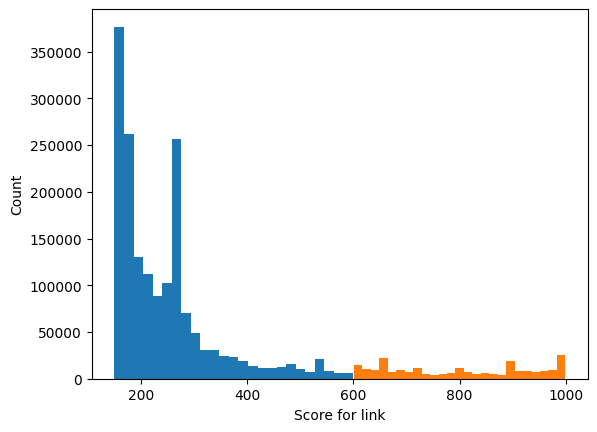

In [ ]:
# set a cutoff for evidence score
cutoff_score = 600

# check how many links are left by a given cutoff score
fig,ax = plt.subplots()
ax.hist(df["combined_score"][df["combined_score"] < cutoff_score],bins=25);
ax.hist(df["combined_score"][df["combined_score"] > cutoff_score],bins=25);
ax.set_xlabel("Score for link")
ax.set_ylabel("Count")

In [ ]:
# remove interactions below the specified score
df = df[df["combined_score"] > 600].dropna()

### Identifier Translation

In [ ]:
# Download info to translate ensembl to entrsz ids.
!wget https://ftp.ensembl.org/pub/current_tsv/homo_sapiens/Homo_sapiens.GRCh38.110.entrez.tsv.gz
!gunzip Homo_sapiens.GRCh38.110.entrez.tsv.gz

--2023-07-19 21:26:07--  https://ftp.ensembl.org/pub/current_tsv/homo_sapiens/Homo_sapiens.GRCh38.110.entrez.tsv.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1980430 (1.9M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.110.entrez.tsv.gz’

Homo_sapiens.GRCh38 100%[===================>]   1.89M   663KB/s    in 2.9s    

2023-07-19 21:26:10 (663 KB/s) - ‘Homo_sapiens.GRCh38.110.entrez.tsv.gz’ saved [1980430/1980430]



In [ ]:
# dictionary that maps ensembl protein ids to entrez gene ids
ensembl_entrez = pd.read_csv("Homo_sapiens.GRCh38.110.entrez.tsv", sep="\t").set_index("protein_stable_id")["xref"].to_dict()
del ensembl_entrez['-']
import numpy as np
def try_ensembl_entrez(ensembl):
  try:
    return ensembl_entrez[ensembl]
  except KeyError:
    return np.nan

### Build a networkx representation of the PPI

In [ ]:
# map the ensemblle protein id to a an entrex id for each edge in the PPI
df["protein1_entrez"] = df.protein1.map(lambda x:try_ensembl_entrez(x.split(".")[1]))
df["protein2_entrez"] = df.protein2.map(lambda x:try_ensembl_entrez(x.split(".")[1]))

In [ ]:
# drop all nodes without a valid entrez id
df = df.dropna(subset=["protein1_entrez","protein2_entrez"])

In [ ]:
# build a networkx graph representation of the PPI
ppi = nx.Graph()
for i,v in df.iterrows():
  ppi.add_edge(v["protein1_entrez"],v["protein2_entrez"])

### Select a subgraph using a gene list

In [ ]:
# Entrez ID's for p53, Tubulin alpha and Tubulin beta
gene_list = ['7157', '7277', '203068']

In [ ]:
# Uncomment if you have your own gene list you want to view.
# you will need to convert them to entrez ids

# import google.colab.files
# google.colab.files.upload



In [ ]:

# you can uuse this code to convert e.g. gene symbols to entrez and vice versa
!wget https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/locus_groups/protein-coding_gene.json
# use the name mapper to convert whatever naming system we have
# in the gene list can be converted to entrez
import json
name_mapper = json.load(open("protein-coding_gene.json"))['response']['docs']

--2023-07-18 19:06:41--  https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/locus_groups/protein-coding_gene.json
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19265855 (18M) [application/json]
Saving to: ‘protein-coding_gene.json’

protein-coding_gene 100%[===================>]  18.37M   482KB/s    in 39s     

2023-07-18 19:07:20 (480 KB/s) - ‘protein-coding_gene.json’ saved [19265855/19265855]



In [ ]:
import itertools as it
import collections
# Select only those nodes which are in the gene set OR are attached to at least two nodes in the gene set.

# Count the neighbors of each node in the gene list in the ppi network.
neighbors_of_gene_list = set(it.chain(*[set(ppi.neighbors(i)) for i in gene_list]))

gene_list = set(gene_list)
# Create a subgraph (G_unfilltered) of the ppi network that includes the nodes from the gene list and their neighbors.
G_unfiltered = ppi.subgraph(gene_list.union(neighbors_of_gene_list))

NameError: ignored

In [ ]:
# Calculate the degrees of nodes in the graph G_unfiltered
node_degrees = [(node, degree) for node, degree in nx.degree(G_unfiltered)]

# Filter nodes that have a degree greater than or equal to 2
nodes_with_degree_at_least_2 = [node for node, degree in node_degrees if degree >= 2]

G = G_unfiltered.subgraph(nodes_with_degree_at_least_2)

NameError: ignored

In [ ]:
# Here we use the capacity of networkx to store attributes in of the nodes in the network
# which is very helpful when we want to relabell node names (which we do later)
for i in G.nodes():
  G.nodes()[i]["in_gene_list"] = (i in gene_list)

In [ ]:
for i in name_mapper[0].keys():
  print(i)

In [ ]:
# Gene symbols are more recognizable than entrez ids, so we
# relabel the network nodes with the corresponnding symbls
entrez_symbol = {i['entrez_id']:i['symbol'] for i in name_mapper}
G = nx.relabel_nodes(G, entrez_symbol.get)

### Function for plotly preview

In [ ]:

def plotly_preview(network,positions,node_colors = 'blue',outfile = 'my_preview.html'):
    """
    Generates a 3D network visualization using Plotly library and saves it as an HTML file.

    Args:
        network (networkx.Graph): The network graph.
        positions (dict): A dictionary containing the positions of nodes in 3D space.
        node_colors (str or dict, optional): The color of nodes in the visualization. It can be a string representing a single color for all nodes or a dictionary mapping node IDs to colors.
        outfile (str, optional): The name of the output HTML file.

    Example:
        import networkx as nx
        # Create a network graph
        network = nx.Graph()
        network.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
        # Define positions of nodes
        positions = {1: (0, 0, 0), 2: (1, 0, 0), 3: (0, 1, 0), 4: (1, 1, 0)}
        # Generate and save the 3D network visualization
        plotly_preview(network, positions, node_colors='red', outfile='network_preview.html')
    """


    if isinstance(node_colors, dict):
        node_colors = list(node_colors.values())

    # Prepare node and edge traces for Plotly
    node_trace = go.Scatter3d(
        x=[positions[node][0] for node in network.nodes()],
        y=[positions[node][1] for node in network.nodes()],
        z=[positions[node][2] for node in network.nodes()],
        mode='markers',
        marker=dict(
            size=3,
            color=node_colors,
        ),
        text=[str(node) for node in network.nodes()],
        hoverinfo='text'
    )
    x_edge = []
    y_edge = []
    z_edge = []

    for a, b in network.edges():
        x_edge.append(positions[a][0])
        x_edge.append(positions[b][0])
        y_edge.append(positions[a][1])
        y_edge.append(positions[b][1])
        z_edge.append(positions[a][2])
        z_edge.append(positions[b][2])

    edge_trace = go.Scatter3d(
        x=x_edge,
        y=y_edge,
        z=z_edge,
        mode='lines',
        line=dict(
            color='#aaaaaa',
            width=1,
        ),
        hoverinfo='none'
    )

    # Step 3: Create layout and add traces
    layout = go.Layout(
        title='3D Network Visualization',
        showlegend=False,
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        hovermode='closest'
    )

    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

    # Display the plot inline in the notebook
    iplot(fig)

    fig.write_html(outfile, auto_open=True)



### layout

For positioning the nodes in 3D space, we use the spring layout, which is considered the most popular method.

However, for larger networks, this approach has certain drawbacks. It often results in a somewhat pointless layout known as "hairball," which is difficult for the human eye to comprehend and tends to obscure structural patterns.

Therefore, we will offer some alternative network layouts later.

In [ ]:
# use networkx's node annotations to get a colromapping for the relabeled network
node_colors = {i:("#E15554" if G.nodes()[i]["in_gene_list"] else "#3F7CAC") for i in G.nodes()}

In [ ]:
# Generate three-dimensional coordinates
# spring- (organic-) layout
pos3D_spg = nx.spring_layout(G, dim=3)
plotly_preview(G,pos3D_spg,node_colors = node_colors,outfile = 'PPI_subnetwork.html')


In [ ]:
# uncomment for quick download on google colab
import google.colab
google.colab.files.download('PPI_subnetwork.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### prepare VR upload

To prepare for the VR upload, several properties of the network need to be stored as Graph attributes with specific keys. These properties include:


* Node positions
* Node colors
* Edge colors
* Node annotations
* Communities of nodes (optional)


The following cell provides a step-by-step walkthrough to fulfill these requirements.

Finally, the resulting Graph object is converted into a JSON file, which can be directly used with the VR uploader.


In [ ]:
def make_json(name, network, positions, node_color = '#40b9d4', link_color = '#999999', annotations = 'None', communities = 'None'):
    """
    Generates a JSON file from a given network graph using the specified parameters.

    Args:
        name (str, optional): Name of the graph.
        network (networkx.Graph): Network graph object.
        positions (dict): Dictionary mapping node IDs to their positions.
        node_color (dict): Dictionary mapping node IDs to their (hex-)colors.
        link_color (str or dict): (Hex-)color value for all links in the graph or dict with node tuple as key and hex color as value.
        communities (dict): 'None' for no communities (default) or dictionary mapping node IDs to their corresponding community ID.
        annotations (dict): Dictionary mapping node IDs to a list of annotations.

    Returns:
        None

    """

    # --------------------------
    # Generate VR GRAPH
    # --------------------------
    GVR = nx.Graph()
    GVR.graph['name'] = name

    # --------------------------------------
    # LOOKUP FOR NODE NAMES INTO IDs and vv
    # --------------------------------------
    d_idx_node = {}
    d_node_idx = {}
    for i, node in enumerate(sorted(network.nodes())):
        d_idx_node[i] = node
        d_node_idx[node] = i
    GVR.add_nodes_from(d_idx_node.keys())

    for edge in network.edges()(data=True):
        GVR.add_edge(d_node_idx[edge[0]],d_node_idx[edge[1]])

    # --------------------------
    # POS
    # --------------------------
    if isinstance(positions[next(iter(positions))], list):
        pass
    else:
        for key in positions:
            positions[key] = positions[key].tolist()

    posG = {d_node_idx[node]: list(xyz) for node, xyz in positions.items()}
    nx.set_node_attributes(GVR, posG, name="pos")

    # # --------------------------
    # # CLUSTER
    # # --------------------------
    if communities == 'None':
        dict_for_cluster = dict(zip(d_idx_node.keys(), [0 for _ in d_idx_node.keys()]))
    else:
        d_VRids_cluster = {d_node_idx[node]: str(cl_id) for node, cl_id in communities.items()}
        nx.set_node_attributes(GVR, d_VRids_cluster, name="cluster")


    # --------------------------
    # NODE COLOR
    # --------------------------
    d_node_colors={}

    if isinstance(node_color, dict):
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color[d_idx_node[nodeid]]
    else:
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color

    nx.set_node_attributes(GVR, d_node_colors, name="nodecolor")

    # --------------------------
    # LINK COLOR
    # --------------------------
    if isinstance(link_color, dict):
        # for different link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            try:
                color = link_color[(d_idx_node[a],d_idx_node[b])]
            except KeyError:
                color = link_color[(d_idx_node[b],d_idx_node[a])]
            d_edge_color[(a,b)] = color
    else:
        # for unique link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            d_edge_color[(a,b)] = link_color

    nx.set_edge_attributes(GVR, d_edge_color, name="linkcolor")

    # --------------------------
    # NODE ANNOTATION
    # --------------------------
    if isinstance(annotations, dict):

        l_annotations = [[str(d_idx_node[nodeid])] + [ annotation for annotation in annotations[d_idx_node[nodeid]]] for nodeid in sorted(GVR.nodes())]
        d_annotations = dict(zip(sorted(GVR.nodes()), l_annotations))
    else:
        d_annotations = {nodeid: [str(d_idx_node[nodeid])] for nodeid in GVR.nodes()}

    nx.set_node_attributes(GVR, d_annotations, name="annotation")

    # --------------------------
    # MAKE JSON fo uploader
    # --------------------------

    G_json = json.dumps(nx.node_link_data(GVR))

    with open(GVR.name, "w") as outfile:
        outfile.write(G_json)


Make JSON files required for the VR uploader

In [ ]:

make_json(name = 'PPI_subnetwork.json', network=G, positions=pos3D_spg)


In [ ]:
# uncomment for quick download on google colab
import google.colab
google.colab.files.download('PPI_subnetwork.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>